In [ ]:
import sys
sys.path.append('../')
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import optax
from functools import partial
import matplotlib.pyplot as plt
from windows import initInterval, cosine, norm, unnorm
from matrix_builder import generate_indices
from matrix_builder import elmfbpinn 
from matrix_builder_old import elmfbpinn_old
from networks import phi,phi_dx,phi_dxx, phi_old, phi_dx_old, phi_dxx_old
from utils import display_windows

key = random.PRNGKey(0) 

# Define the exact solution for the damped harmonic oscillator
m = 1
delta = 2
mu = 2 * delta
omega_0 = 80
k = omega_0**2
omega = jnp.sqrt(omega_0**2 - delta**2)

def general_solution(u_0,u_1,t):
    
    return jnp.exp(-delta*t)*(u_0*(delta*jnp.sin(omega*t) + omega*jnp.cos(omega*t)) + u_1*jnp.sin(omega*t))/omega

def generate_u_exacts(u_0,u_1,x_batch):
    def single_initial_condition_func(u_0,u_1,x):
        return general_solution(u_0,u_1,x)
    
    return jax.vmap(jax.vmap(single_initial_condition_func,in_axes=(None,None,0)),in_axes=(0,0,None))(u_0,u_1,x_batch)



def zero_RHS(t):
    return 0.0 * t

def initWeightBiases(n_initial_conditions,nSubdomains, layer,R=None):
    params_hidden = []  # To store hidden layer parameters
    for i in range(len(layer) - 2):  # Loop through hidden layers only
        key = random.PRNGKey(i)
        w_key_hidden, b_key_hidden, key = random.split(key, 3)
        
        # Calculate weight initialization scale
        if R is None: # He initialization
            v = jnp.sqrt(2. / (layer[i] + layer[i + 1]))
            jax.debug.print("Sampling Range of weights: {v}",v=v)
            W = random.uniform(w_key_hidden, (layer[i], layer[i + 1]), minval=-v, maxval=v)
            b = random.uniform(b_key_hidden, (layer[i + 1],), minval=-v, maxval=v)
        
        else: # Random initialization
            key = random.PRNGKey(0)
            w_key_hidden, b_key_hidden, key = random.split(key, 3)
            W = random.uniform(w_key_hidden, (layer[i], layer[i + 1]), minval=-R, maxval=R)
            b = random.uniform(b_key_hidden, (layer[i + 1],), minval=-R, maxval=R)
        
        params_hidden.append((W, b))
    
    # Output layer (unique weights and biases for each subdomain)
    key = random.PRNGKey(len(layer) - 2)  # Ensure a new key for the output layer
    w_key, b_key, key = random.split(key, 3)
    
    if R is None: 
        v = jnp.sqrt(2. / (layer[-2] + layer[-1]))
        #jax.debug.print("outer v: {v}",v=v)
        W_out = random.uniform(w_key, (n_initial_conditions,nSubdomains, layer[-2], layer[-1]), minval=-v, maxval=v)
        b_out = random.uniform(b_key, (n_initial_conditions,nSubdomains, layer[-1]), minval=-v, maxval=v)
    
    else:
        key = random.PRNGKey(0)
        w_key_out, b_key_out, key = random.split(key, 3)
        W_out = random.uniform(w_key, (n_initial_conditions,nSubdomains, layer[-2], layer[-1]), minval=-R, maxval=R)
        b_out = random.uniform(b_key, (n_initial_conditions,nSubdomains, layer[-1]), minval=-R, maxval=R)
    
    params_out = (W_out, b_out)
    
    return params_hidden, params_out, w_key_hidden,b_key_hidden

def initInterval(nSubdomains, xmin, xmax, width=1.9, verbose=False):
    sd = (xmax - xmin) / nSubdomains
    xc = jnp.linspace(xmin, xmax, nSubdomains)
    xmins = xc - width*sd
    xmaxs = xc + width*sd
    if verbose:
        display_windows(xmins, xmaxs)
    return jnp.stack([xmins, xmaxs], axis=-1)

# Normalization and denormalization functions
def norm(mu, sd, x):
    return (x - mu) / sd

def unnorm(mu, sd, x):
    return x * sd + mu

# Forward pass through the neural network
def forward(x, params_hidden, params_outer_layer,sigma): #[1,C,1]
    for weight, bias in params_hidden:
        x = sigma(jnp.dot(x, weight) + bias)
    
    #jax.debug.print("Params_outer_layer: {params_outer_layer}",params_outer_layer=params_outer_layer)

    final_weight, final_bias = params_outer_layer
    return jnp.dot(x, final_weight) + final_bias

# Function to be vmapped across the x points and subdomains
def inner(params_hidden, params_outer_layer, ranges, x, sigma):
    xmin, xmax = ranges
    mu = (xmin + xmax) / 2
    sd = (xmax - xmin) / 2

    w = window_hat(x, xmin, xmax)
    x = norm(mu, sd, x)
    x = forward(x, params_hidden, params_outer_layer, sigma)
    x = unnorm(0, 1, x)

    return w * x

def cosine(xmin,xmax, x):
    mu, sd = (xmin+xmax)/2, (xmax-xmin)/2
    ws = ((1+jnp.cos(jnp.pi*(x-mu)/sd))/2)**2
    ws = jnp.heaviside(x-xmin,1)*jnp.heaviside(xmax-x,1)*ws
    w = jnp.prod(ws, axis=0, keepdims=True)
    return w

# Partition of Unity window function
def window_hat(x, xmin, xmax):
    condition = jnp.logical_and(x >= xmin, x <= xmax)
    mu = (xmin + xmax) / 2.0
    sd = (xmax - xmin) / 2.0
    return jnp.where(condition, (1 + jnp.cos(jnp.pi * (x - mu) / sd)) ** 2, 0)

def model(params, ranges, x, sigma):
    us = jax.vmap(
        jax.vmap(
        jax.vmap(inner, in_axes=(None, None, None, 0, None)),  # Inner vmap for each x
        in_axes=(None, 0, 0, None, None)  # Outer vmap for each subdomain j
    ),in_axes=(None,0,None,None,None))(params[0], params[1], ranges, x, sigma) #params[0]- hidden shared weights, params[1] - output weights, n_ic,J number of subdomains

    return jnp.sum(us, axis=1)

#supervised loss
def single_loss_fn(params, ranges, x, y,sigma):
    # Get the model predictions
    u = model(params, ranges, x,sigma)
    
    # Compute the mean squared error loss
    return jnp.mean((u - y) ** 2)

def sum_losses(params, ranges, x, y, sigma):
    loss_fn = lambda y_single: single_loss_fn(params, ranges, x, y_single, sigma)
    losses = jax.vmap(loss_fn)(y)  # Apply single_loss_fn to each y in parallel
    return jnp.sum(losses)

# Training step
#from jax import jit
@partial(jax.jit, static_argnums=(5,6))
def train_step(params, ranges, opt_state, x, y, optimizer,sigma):
    # Compute the gradient of the loss function
    loss, grads = jax.value_and_grad(sum_losses, has_aux=False)(params, ranges, x, y,sigma)

    # Apply the updates to the parameters
    updates, opt_state = optimizer.update(grads, opt_state)

    # Apply the updates to the entire params
    params = optax.apply_updates(params, updates)

    return params, opt_state, loss



In [2]:
key = random.PRNGKey(42)
n_ic = 1000
mean = 0.5
std = 0.2
ic_min = 0.0  # Desired minimum
ic_max = 1.0   # Desired maximum

def truncated_normal_sample(key, shape, mean, std, minval, maxval):
    samples = random.truncated_normal(key, lower=(minval - mean) / std, upper=(maxval - mean) / std, shape=shape)
    return samples * std + mean  # Scale and shift


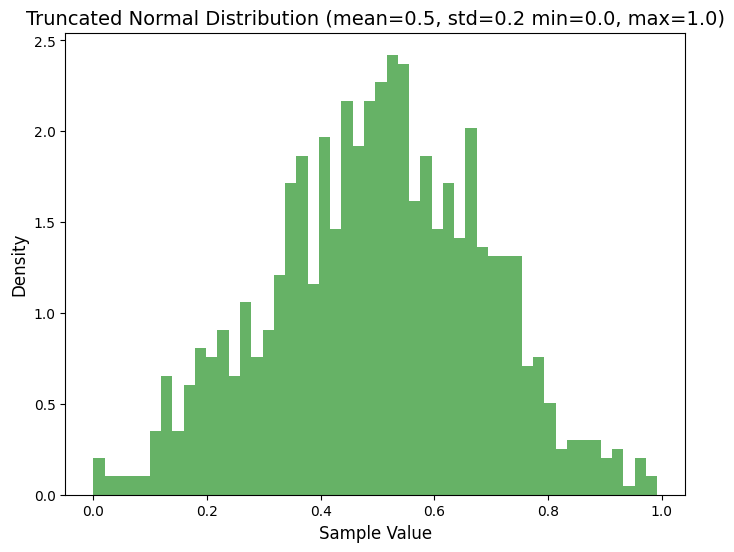

In [5]:
# Generate the samples
key = random.PRNGKey(0)
samples = truncated_normal_sample(key, shape=(n_ic,), mean=mean, std=std, minval=ic_min, maxval=ic_max)

# Plot the histogram to visualize the truncated Gaussian
plt.figure(figsize=(8, 6))
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g')

# Add a title and labels
plt.title(f"Truncated Normal Distribution (mean={mean}, std={std} min={ic_min}, max={ic_max})", fontsize=14)
plt.xlabel("Sample Value", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Show the plot
plt.show()


In [4]:
def basis_pretrain(n_ic,layer_sizes, J, xmin, xmax, nSamples, epochs, epoch_print, learning_rate, sigma, ic_mean,ic_std,ic_min,ic_max,R=None):
    # Initialize random key and parameters
    key = random.PRNGKey(0)

    u_0 = truncated_normal_sample(key, (n_ic,), ic_mean, ic_std, minval=ic_min, maxval=ic_max)

    reversed_u_1 = truncated_normal_sample(key, (n_ic,), ic_mean, ic_std, minval=ic_min, maxval=ic_max)
    u_1 = reversed_u_1[::-1]
    
    # Initialize the weights and biases for the hidden and output layers
    params_hidden, initial_params_out, w_key,b_key = initWeightBiases(n_ic,J, layer_sizes,R)
    #jax.debug.print("params_out: {params_out}",params_out=initial_params_out)
    params = (params_hidden, initial_params_out)
    
    # Initialize the subdomains
    ranges = initInterval(J, xmin, xmax,width=1.9,verbose=False)
    
    # Create training data
    x_train = jnp.linspace(xmin, xmax, nSamples).reshape(-1, 1)
    #y_train = harm_u_exact(x_train)
    y_train = generate_u_exacts(u_0,u_1,x_train)
    
    # Initialize optimizer (Adam optimizer)
    key, subkey = random.split(key)
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    
    # Training loop
    for epoch in range(epochs):
        # Perform one training step
        # print(f"before params: {params}")
        params, opt_state, loss = train_step(params, ranges, opt_state, x_train, y_train, optimizer, sigma)
        #print(f"after params: {params}")
        # Print loss every 1000 epochs
        if epoch % epoch_print == 0:
            print(f"Epoch {epoch}, Loss: {loss:.9f}")
    
    # Return the trained parameters, optimizer state, and final loss
    return initial_params_out, params,ranges, opt_state, key, w_key,b_key, u_0, u_1, y_train

In [3]:
def plot_initial_condition(xmin, xmax, nSamples, pre_train_params, pre_train_ranges, y_train, sigma, idx):

    x_train = jnp.linspace(xmin, xmax, nSamples).reshape(-1, 1)
    u_pred = model(pre_train_params, pre_train_ranges, x_train, sigma)
    plt.plot(x_train,y_train[idx],label="Exact")
    plt.plot(x_train,u_pred[idx],label="Prediction")
    plt.title(f"Exact vs Prediction: Initial Condition: {idx}")
    plt.legend()
    plt.show()

In [ ]:
# import numpy as np

# # Function to evaluate activations of the hidden units
# def get_hidden_activations(x_vals, params,sigma):
#     activations = []
#     x = x_vals
#     for weight, bias in params[0]:  # Iterate over all hidden layers
#         x = sigma(jnp.dot(x, weight) + bias)
#         activations.append(x)
    
#     plt.figure(figsize=(15, 10))
#     for i, activation in enumerate(activations):
#         plt.plot(x_vals, activation, label=f'Hidden Unit {i+1}')
        
#     plt.xlabel('Input x')
#     plt.ylabel('Activation')
#     plt.title(f'Activation of Hidden Units: {sigma.__name__}')
#     plt.grid()
#     plt.show()
#     return activations

In [ ]:
# # Generate a set of x values to evaluate the activations
# x_vals = jnp.linspace(0, 1, nSamples).reshape(-1, 1)
# # Get the activations for the hidden units
# hidden_activations = get_hidden_activations(x_vals, sin_params,jnp.sin)


In [ ]:
# hidden_activations = get_hidden_activations(x_vals, sin_params,jnp.tanh)# 

### Old Function test

Creating M_ode...
M_ode created in 0.14 seconds.
Creating B_train...
B_train created in 0.30 seconds.
Training loss: 3.90e-02
Full training loss: 4.03e-02
Time taken for solver: 0.0098 seconds
Creating M_sol...
M_sol created in 0.17 seconds.
Test Loss Value: 2.73e-02


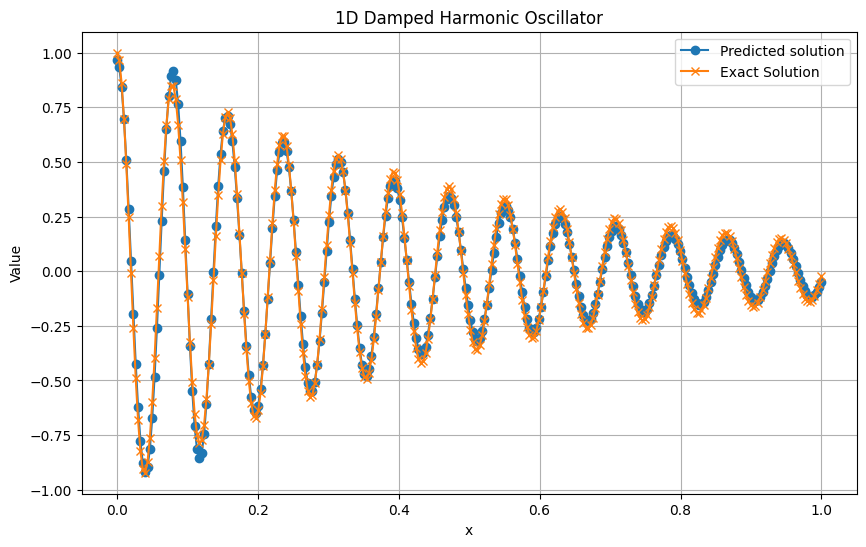

Condition number of M_ode_sparse: 1.73e+10
Condition number of M_sol_sparse: 8.61e+10
Condition Number of LHS: 2.29e+12
Total time taken: 1.05 seconds.


In [ ]:
RHS_func = zero_RHS
u_func = exact_solution_cos
n_train = 150
n_test = 300
J=20
C=32
R=0.24
width = 1.9
sigma = jnp.sin
xmin,xmax= 0,1
title = "1D Damped Harmonic Oscillator"
old_results = elmfbpinn_old(
    RHS_func,
    u_func,
    n_train,
    n_test,
    J,
    C,
    R,
    xmin,
    xmax,
    width,
    sigma,
    title,
    w_key,
    b_key,
    lmda=1,
    plot_window=False,
    debug=False
)

### Sin params - Trained

In [99]:
layer_sizes = [1, 32, 1]
J = 20
R = None # He Initialisation
xmin, xmax = 0, 1
nSamples = 150
epochs = 30
epoch_print = epochs/10
learning_rate = 1e-3
n_ic = 100
ic_min = 0
ic_max = 1
ic_mean = 0.5
ic_std = 0.2
sigma = jnp.tanh

initial_params_out, pre_train_params, pre_train_ranges, sin_opt_state,key, w_key,b_key, u_0, u_1, y_train= basis_pretrain(n_ic,layer_sizes, J, xmin, xmax, nSamples, epochs, epoch_print, learning_rate, sigma, ic_mean,ic_std,ic_min,ic_max,R=None)

Sampling Range of weights: 0.24618297815322876
Epoch 0, Loss: 61.282890320
Epoch 3, Loss: 51.948005676
Epoch 6, Loss: 44.044898987
Epoch 9, Loss: 37.417663574
Epoch 12, Loss: 31.891523361
Epoch 15, Loss: 27.289295197
Epoch 18, Loss: 23.453327179
Epoch 21, Loss: 20.251399994
Epoch 24, Loss: 17.574104309
Epoch 27, Loss: 15.334398270


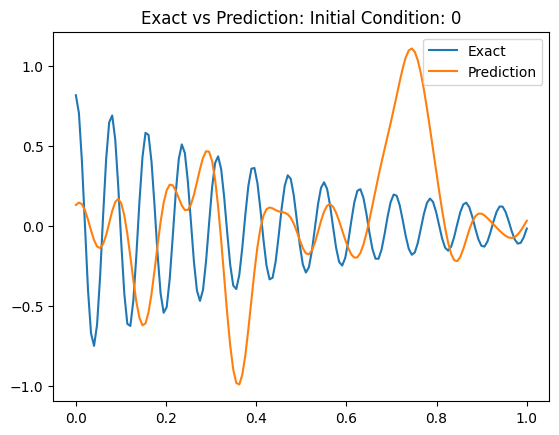

In [101]:
plot_initial_condition(xmin, xmax, nSamples, pre_train_params, pre_train_ranges, y_train, sigma, idx=0)

Creating M_ode...
M_ode created in 0.09 seconds.
Creating B_train...
Training loss: 5.03e-02
Full training loss: 5.22e-02
Time taken for solver: 0.0039 seconds
Creating M_sol...
M_sol created in 0.06 seconds.
Test Loss Value: 4.48e-02
x_test shape: (300, 1)
u_test shape: (300,)
u_exact shape: (300,)


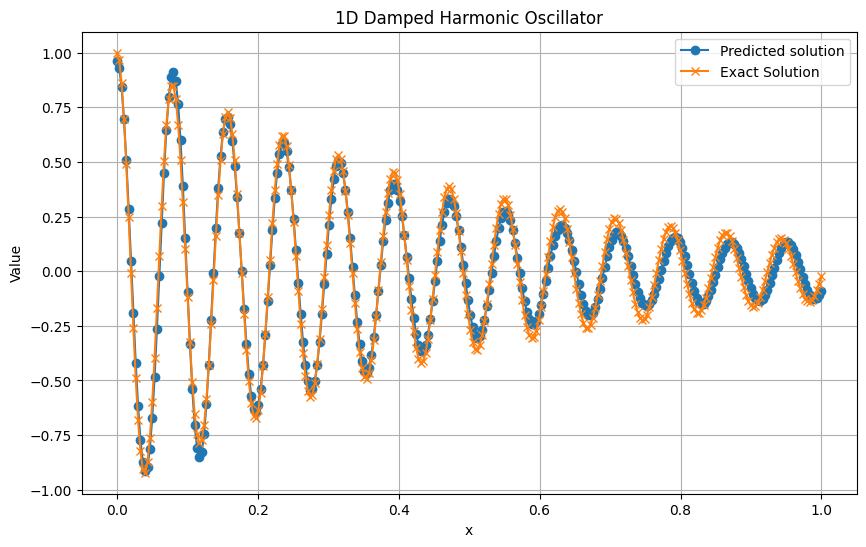

Condition number of M_ode_sparse: 1.29e+10
Condition number of M_sol_sparse: 4.22e+11
Condition number of LHS: 2.88e+12
Total time taken: 0.85 seconds.


In [102]:
params_hidden, params_out = pre_train_params
hidden_weights = params_hidden[0][0]
# a_pre_trained = params_out[0]
# hidden_biases = params_hidden[0][1]

x_train = jnp.linspace(0, 1, 150).reshape(-1, 1)

RHS_func = zero_RHS
u_0 = jnp.array([1.0])
u_1 = jnp.array([0.0])
u_func = generate_u_exacts
n_train = 150
n_test = 300
J=20
width = 1.9
sigma = jnp.tanh
xmin,xmax= 0,1
title = "1D Damped Harmonic Oscillator"
trained_results = elmfbpinn(
    u_0,
    u_1,
    RHS_func,
    u_func,
    n_train,
    n_test,
    J,
    pre_train_ranges,
    xmin,
    xmax,
    width,
    sigma,
    title,
    params_hidden,
    lmda=1,
    plot_window=False,
    debug=False,
)

### Sin params - Initialised, untrained

Sampling Range of weights: 0.24618297815322876
Creating M_ode...
M_ode created in 0.08 seconds.
Creating B_train...
Training loss: 3.90e-02
Full training loss: 4.05e-02
Time taken for solver: 0.0043 seconds
Creating M_sol...
M_sol created in 0.06 seconds.
Test Loss Value: 2.62e-02
x_test shape: (300, 1)
u_test shape: (300,)
u_exact shape: (300,)


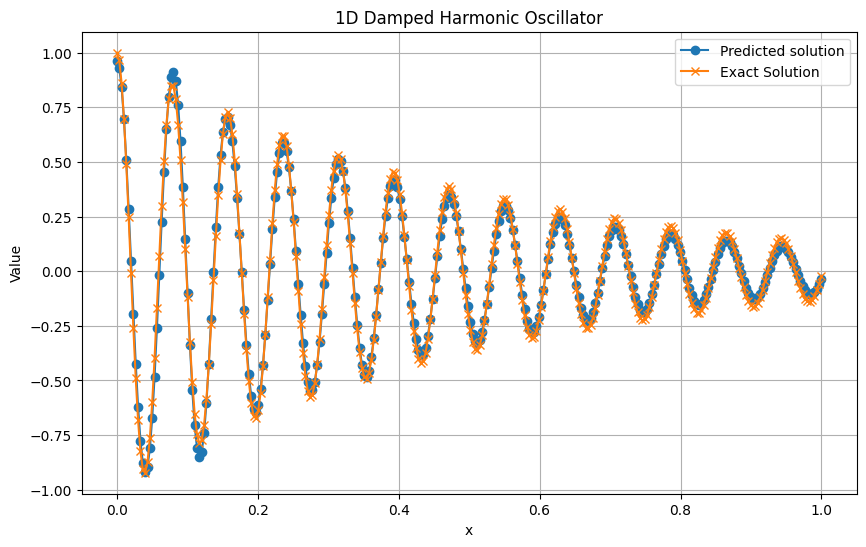

Condition number of M_ode_sparse: 6.18e+10
Condition number of M_sol_sparse: 1.84e+11
Condition number of LHS: 3.00e+12
Total time taken: 0.91 seconds.


In [85]:
RHS_func = zero_RHS
u_func = generate_u_exacts
u_0 = jnp.array([1.0])
u_1 = jnp.array([0.0])
n_train = 150
n_test = 300
J=20
C=32
R=None
params_hidden, params_out, w_key_hidden,b_key_hidden = initWeightBiases(1,J, [1,C,1],R=R)
width = 1.9
sigma = jnp.tanh
xmin,xmax= 0,1
title = "1D Damped Harmonic Oscillator"

untrained_results = elmfbpinn(
    u_0,
    u_1,
    RHS_func,
    u_func,
    n_train,
    n_test,
    J,
    pre_train_ranges,
    xmin,
    xmax,
    width,
    sigma,
    title,
    params_hidden,
    lmda=1,
    plot_window=False,
    debug=False,
)

In [75]:
lsq, Ms, B, a, u, loss, x, f, lhs_condition, xmins, xmaxs, total_elapsed_time, rows, columns = trained_results
M_ode_sparse, B_ode_scaled, lmda, exact_solution, g_train = lsq

In [ ]:
import scipy.sparse as sp
u_train_pretrained = M_ode_sparse@a_pre_trained.reshape(640,)
B_csc = sp.csc_matrix(B_ode_scaled)

jnp.linalg.norm(M_ode_sparse @ a_pre_trained.reshape(640,) - f, ord=2) ** 2 + lmda * jnp.linalg.norm(B_csc @ a_pre_trained.reshape(640,) - g_train, ord=2) ** 2

Array(6.845705, dtype=float32)

In [77]:
jnp.linalg.norm(M_ode_sparse @ a - f, ord=2) ** 2 + lmda * jnp.linalg.norm(B_csc @ a - g_train, ord=2) ** 2

Array(0.11919414, dtype=float32)

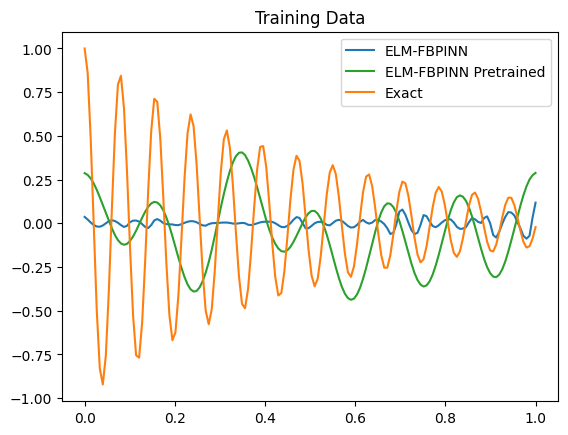

In [78]:
u_train_elm = M_ode_sparse@a
u_train_pretrained = M_ode_sparse@a_pre_trained.reshape(640,)
x_train = x[0]
u_exact_train = exact_solution_cos(x_train)

colors = plt.cm.tab10.colors

plt.plot(x_train, u_train_elm, label="ELM-FBPINN", color=colors[0])  # blue
plt.plot(x_train, u_train_pretrained, label="ELM-FBPINN Pretrained", color=colors[2])  # green
plt.plot(x_train, u_exact_train, label="Exact", color=colors[1])  # orange
plt.title("Training Data")
plt.legend()
plt.show()